In [8]:
#!pip install git+https://github.com/PSLmodels/scf.git
#!pip install git+https://github.com/pslmodels/scf/
#!pip install quantile_forest

## Imputation of the Survey of Consumer Finances with Quantile Regression Forests

In [9]:
import microdf as mdf
import scf
import pandas as pd
from typing import Union
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

VALID_YEARS = [
    1989,
    1992,
    1995,
    1998,
    2001,
    2004,
    2007,
    2010,
    2013,
    2016,
    2019,
]

def scf_url(year: int) -> str:
    """ Returns the URL of the SCF summary microdata zip file for a year.

    :param year: Year of SCF summary microdata to retrieve.
    :type year: int
    :return: URL of summary microdata zip file for the given year.
    :rtype: str
    """
    assert year in VALID_YEARS, "The SCF is not available for " + str(year)
    return (
        "https://www.federalreserve.gov/econres/files/scfp"
        + str(year)
        + "s.zip"
    )


def load_single_scf(year: int, columns: list) -> pd.DataFrame:
    """ Loads SCF summary microdata for a given year and set of columns.

    :param year: Year of SCF summary microdata to retrieve.
    :type year: int
    :param columns: List of columns. The weight column `wgt` is always
        returned. Defaults to all columns in the summary dataset.
    :type columns: list
    :return: SCF summary microdata for the given year.
    :rtype: pd.DataFrame
    """
    # Add wgt to all returns.
    if columns is not None:
        columns = list(set(columns) | set(["wgt"]))
    return mdf.read_stata_zip(scf_url(year), columns=columns)


def load(
    years: list = VALID_YEARS,
    columns: list = None,
    as_microdataframe: bool = False,
) -> Union[pd.DataFrame, mdf.MicroDataFrame]:
    """ Loads SCF summary microdata for a set of years and columns.

    :param years: Year(s) to load SCF data for. Can be a list or single number.
        Defaults to all available years, starting with 1989.
    :type years: list
    :param columns: List of columns. The weight column `wgt` is always returned.
    :type columns: list
    :param as_microdataframe: Whether to return as a MicroDataFrame with
        weight set, defaults to False.
    :type as_microdataframe: bool
    :return: SCF summary microdata for the set of years.
    :rtype: Union[pd.DataFrame, mdf.MicroDataFrame]
    """
    # Make cols a list if a single column is passed.
    if columns is not None:
        columns = mdf.listify(columns)
    # If years is a single year rather than a list, don't use a loop.
    if isinstance(years, int):
        res = load_single_scf(years, columns)
    # Otherwise append to a list within a loop, and concatenate.
    else:
        scfs = []
        for year in years:
            tmp = load_single_scf(year, columns)
            tmp["year"] = year
            scfs.append(tmp)
        res = pd.concat(scfs)
    # Return as a MicroDataFrame or DataFrame.
    if as_microdataframe:
        return mdf.MicroDataFrame(res, weights="wgt")
    return res

## CPS Columns of Interest

In [10]:
import requests
from io import BytesIO
from zipfile import ZipFile
import pandas as pd

# URL for the 2019 CPS dataset
CPS_2019_URL = "https://www2.census.gov/programs-surveys/cps/datasets/2020/march/asecpub20csv.zip"

# Download the zip file
response = requests.get(CPS_2019_URL, stream=True)
if response.status_code == 200:
    with ZipFile(BytesIO(response.content)) as zipfile:
        # List all files in the ZIP archive
        file_list = zipfile.namelist()
        print("Files in ZIP archive:", file_list)

        # Load each dataset
        with zipfile.open("pppub20.csv") as f:
            person_df = pd.read_csv(f)
        with zipfile.open("ffpub20.csv") as f:
            family_df = pd.read_csv(f)
        with zipfile.open("hhpub20.csv") as f:
            household_df = pd.read_csv(f)

        # Display the first few rows of each dataset
        print("Person Data Columns:", person_df.columns)
        print("Family Data Columns:", family_df.columns)
        print("Household Data Columns:", household_df.columns)
else:
    print("Failed to download the dataset.")


Files in ZIP archive: ['hhpub20.csv', 'ffpub20.csv', 'pppub20.csv', 'asec_csv_repwgt_2020.csv']
Person Data Columns: Index(['PERIDNUM', 'PH_SEQ', 'P_SEQ', 'A_LINENO', 'PF_SEQ', 'PHF_SEQ',
       'OED_TYP1', 'OED_TYP2', 'OED_TYP3', 'PERRP',
       ...
       'M5G_CBST', 'M5G_DSCP', 'CLWK', 'DEP_STAT', 'FILEDATE', 'FILESTAT',
       'LJCW', 'NOEMP', 'WECLW', 'YYYYMM'],
      dtype='object', length=840)
Family Data Columns: Index(['FPOVCUT', 'FPERSONS', 'FHEADIDX', 'FSPOUIDX', 'FOWNU6', 'FRELU6',
       'FKIND', 'FKINDEX', 'FTYPE', 'FRELU18', 'FOWNU18', 'FLASTIDX',
       'FMLASIDX', 'FH_SEQ', 'FAMLIS', 'FANNVAL', 'FCSPVAL', 'FDISVAL',
       'FDIVVAL', 'FDSTVAL', 'FEARNVAL', 'FEDVAL', 'FFINVAL', 'FFPOS',
       'FFRVAL', 'FHIP_VAL', 'FHIP_VAL2', 'FINC_ANN', 'FINC_CSP', 'FINC_DIS',
       'FINC_DIV', 'FINC_DST', 'FINC_ED', 'FINC_FIN', 'FINC_FR', 'FINC_INT',
       'FINC_OI', 'FINC_PAW', 'FINC_PEN', 'FINC_RNT', 'FINC_SE', 'FINC_SS',
       'FINC_SSI', 'FINC_SUR', 'FINC_UC', 'FINC_VET', 'FI

In [11]:
for column in person_df.columns:
    print(column)
    break # remove to see all columns in dataset

for column in household_df.columns:
    print(column)
    break # remove to see all columns in dataset

# see https://www2.census.gov/programs-surveys/cps/methodology/PublicUseDocumentation_final.pdf and
# https://www2.census.gov/programs-surveys/cps/datasets/2020/march/ASEC2020ddl_pub_full.pdf 

PERIDNUM
H_IDNUM


In [ ]:
# Messy, just some CPS variables for reference

cps_predictors = ["is_household_head",
        "age",
        "is_male",
        "tenure_type",
        "employment_income",
        "self_employment_income",
        "social_security",
        "pension_income",
        "household_size",]


cps["own_children_in_household"] = tmp.children.fillna(0)

cps["has_marketplace_health_coverage"] = person.MRK == 1

cps["cps_race"] = person.PRDTRACE
cps["is_hispanic"] = person.PRDTHSP != 0

cps["is_widowed"] = person.A_MARITL == 4
cps["is_separated"] = person.A_MARITL == 6
# High school or college/university enrollment status.
cps["is_full_time_college_student"] = person.A_HSCOL == 2

# Assign CPS variables.
cps["employment_income"] = person.WSAL_VAL

cps["weekly_hours_worked"] = person.HRSWK * person.WKSWORK / 52

cps["taxable_interest_income"] = person.INT_VAL * (
    p["taxable_interest_fraction"]
)
cps["tax_exempt_interest_income"] = person.INT_VAL * (
    1 - p["taxable_interest_fraction"]
)
cps["self_employment_income"] = person.SEMP_VAL
cps["farm_income"] = person.FRSE_VAL
cps["qualified_dividend_income"] = person.DIV_VAL * (
    p["qualified_dividend_fraction"]
)
cps["non_qualified_dividend_income"] = person.DIV_VAL * (
    1 - p["qualified_dividend_fraction"]
)
cps["rental_income"] = person.RNT_VAL
# Assign Social Security retirement benefits if at least 62.
MINIMUM_RETIREMENT_AGE = 62
cps["social_security_retirement"] = np.where(
    person.A_AGE >= MINIMUM_RETIREMENT_AGE, person.SS_VAL, 0
)
# Otherwise assign them to Social Security disability benefits.
cps["social_security_disability"] = (
    person.SS_VAL - cps["social_security_retirement"]
)
# Provide placeholders for other Social Security inputs to avoid creating
# NaNs as they're uprated.
cps["social_security_dependents"] = np.zeros_like(
    cps["social_security_retirement"]
)
cps["social_security_survivors"] = np.zeros_like(
    cps["social_security_retirement"]
)
cps["unemployment_compensation"] = person.UC_VAL

## SCF Data Load and Preprocessing

In [13]:
# focus on 2019 SCF data
data = load([VALID_YEARS[-1]])

# split data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, train_size=0.8)

train_df.head()

,yy1,y1,wgt,hhsex,age,agecl,educ,edcl,married,kids,...,inccat,assetcat,ninccat,ninc2cat,nwpctlecat,incpctlecat,nincpctlecat,incqrtcat,nincqrtcat,year
25776,5188,51882,4893.416691,2,45,3,8,2,2,0,...,3,1,3,1,2,5,5,2,2,2019
13143,2644,26444,439.239368,1,50,3,12,4,1,1,...,6,6,6,3,11,10,11,4,4,2019
26476,5328,53282,38.184735,1,76,6,12,4,1,0,...,6,6,6,3,12,12,12,4,4,2019
28427,5721,57213,64.238949,1,76,6,13,4,2,0,...,6,6,6,3,12,12,12,4,4,2019
23719,4772,47725,5960.043856,1,55,4,12,4,1,1,...,4,3,4,2,6,7,7,3,3,2019


In [14]:
for column in train_df.columns:
    print(column)
    break # remove to see all columns in dataset

yy1


In [15]:
# Load demographic predictor variables
dem_predictors = ["income", "age", "married", "kids", 
                     "educ", "race", "lf"] # lf = labor force status

train_df[dem_predictors].describe()

,income,age,married,kids,educ,race,lf
count,2.310800e+04,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000
mean,1.171661e+06,53.238662,1.376709,0.751255,10.252034,1.548641,0.751471
std,1.292835e+07,16.225380,0.484572,1.127448,2.708035,1.056837,0.432169
min,0.000000e+00,18.000000,1.000000,0.000000,-1.000000,1.000000,0.000000
25%,4.248891e+04,40.750000,1.000000,0.000000,8.000000,1.000000,1.000000
50%,9.264943e+04,54.000000,1.000000,0.000000,11.000000,1.000000,1.000000
75%,2.325088e+05,65.000000,2.000000,1.000000,12.000000,2.000000,1.000000
max,8.156336e+08,95.000000,2.000000,7.000000,14.000000,5.000000,1.000000


In [16]:
# Load financial predictor variables
fin_predictors = ["houses", "equity", "trusts", "stocks", "asset", 
                     "saving", "wageinc", "kginc"]

train_df[fin_predictors].describe()

,houses,equity,trusts,stocks,asset,saving,wageinc,kginc
count,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04
mean,8.474683e+05,3.559676e+06,6.433040e+05,1.371608e+06,1.606949e+07,6.660673e+04,1.664648e+05,4.352012e+05
std,3.103222e+06,2.862459e+07,1.115652e+07,1.161028e+07,9.338054e+07,6.144518e+05,1.026294e+06,1.250478e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.030356e+06
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.828079e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.086570e+05,1.124429e+04,0.000000e+00,0.000000e+00,4.228201e+05,2.318411e+01,4.720990e+04,0.000000e+00
75%,5.680106e+05,3.263743e+05,0.000000e+00,0.000000e+00,2.134271e+06,1.159205e+04,1.262865e+05,0.000000e+00
max,1.234322e+08,1.457828e+09,4.636821e+08,4.057219e+08,2.280388e+09,3.245775e+07,5.311114e+07,8.261732e+08


In [17]:
train_df["networth"].describe()

count    2.310800e+04
mean     1.570575e+07
std      9.224071e+07
min     -1.107621e+06
25%      2.445054e+04
50%      2.713352e+05
75%      1.872117e+06
max      2.280388e+09
Name: networth, dtype: float64

In [18]:
# predictors shared with cps data

PREDICTORS = ["hhsex",      # sex of head of household
            "age",          # age of respondent
            "married",      # marital status of respondent
            "kids",         # number of children in household
            "educ",         # highest level of education
            "race",         # race of respondent 
            "income",       # total annual income of household  
            "wageinc",      # income from wages and salaries
            "bussefarminc", # income from business, self-employment or farm
            "intdivinc",    # income from interest and dividends
            "ssretinc",     # income from social security and retirement accounts
            "lf",           # labor force status
            ]   

IMPUTED_VARIABLES = ["networth"] # some property also captured in cps data (HPROP_VAL)

# additional predictors that may be useful for imputing wealth from scf data

scf_imputed_variables = ["networth"]

add_predictors = ["houses", 
                "vehic",
                "equity", 
                "trusts", 
                "stocks", 
                "asset",
                "saving",
                ]

In [19]:
train_df[PREDICTORS].describe()

,hhsex,age,married,kids,educ,race,income,wageinc,bussefarminc,intdivinc,ssretinc,lf
count,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,23108.000000
mean,1.224078,53.238662,1.376709,0.751255,10.252034,1.548641,1.171661e+06,1.664648e+05,4.677982e+05,1.564668e+05,2.102781e+04,0.751471
std,0.416983,16.225380,0.484572,1.127448,2.708035,1.056837,1.292835e+07,1.026294e+06,3.486120e+06,1.921528e+06,8.223668e+04,0.432169
min,1.000000,18.000000,1.000000,0.000000,-1.000000,1.000000,0.000000e+00,0.000000e+00,-2.360495e+06,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,40.750000,1.000000,0.000000,8.000000,1.000000,4.248891e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,1.000000,54.000000,1.000000,0.000000,11.000000,1.000000,9.264943e+04,4.720990e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,1.000000,65.000000,2.000000,1.000000,12.000000,2.000000,2.325088e+05,1.262865e+05,1.770371e+04,1.180247e+03,1.888396e+04,1.000000
max,2.000000,95.000000,2.000000,7.000000,14.000000,5.000000,8.156336e+08,5.311114e+07,1.239260e+08,1.272071e+08,4.730904e+06,1.000000


## Imputing Wealth

In [20]:
import sys
import os

# Get the parent directory of the current script
from policyengine_us_data.utils import QRF

In [21]:
# Choose the imputed variable for our analysis
imputed_variable = ["networth"]

y_train = train_df[imputed_variable]
y_test = test_df[imputed_variable]

In [22]:
# Quantile loss function from https://colab.research.google.com/drive/1E8F7S1Uvfw_3PmpS226Sl1LWV5NBi0CE#scrollTo=cMzFV5QU5RZr 

def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [23]:
# Run a Quantile Regression Forest on demographic predictors
dem_qrf = QRF()
dem_qrf.fit(train_df[dem_predictors], train_df[imputed_variable])

/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [24]:
# Run a Quantile Regression Forest on financial predictors
fin_qrf = QRF()
fin_qrf.fit(train_df[fin_predictors], train_df[imputed_variable])

/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Compare Results

In [25]:
QUANTILES = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

In [26]:
# Compute quantile loss for demographic predictors in train and test sets
dem_train_losses = [np.mean(quantile_loss(q, y_train.values.flatten(),
                                          dem_qrf.predict(train_df[dem_predictors], mean_quantile=q).values.flatten()
                                         )) for q in QUANTILES]
dem_test_losses = [np.mean(quantile_loss(q, y_test.values.flatten(),
                                         dem_qrf.predict(test_df[dem_predictors], mean_quantile=q).values.flatten()
                                        )) for q in QUANTILES]

# Compute quantile loss for financial predictors in train and test sets
fin_train_losses = [np.mean(quantile_loss(q, y_train.values.flatten(),
                                          fin_qrf.predict(train_df[fin_predictors], mean_quantile=q).values.flatten()
                                         )) for q in QUANTILES]
fin_test_losses = [np.mean(quantile_loss(q, y_test.values.flatten(),
                                         fin_qrf.predict(test_df[fin_predictors], mean_quantile=q).values.flatten()
                                        )) for q in QUANTILES]

# Create dataframes for train and test losses
dem_loss_df = pd.DataFrame([dem_train_losses, dem_test_losses], columns=quantiles_legend, index=["Train", "Test"])
fin_loss_df = pd.DataFrame([fin_train_losses, fin_test_losses], columns=quantiles_legend, index=["Train", "Test"])

In [27]:
dem_loss_df

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,483889.982958,8.689220e+05,1.544056e+06,1.452119e+06,1.052197e+06,1.008559e+06,6.648588e+05
Test,656693.314046,1.125505e+06,2.899134e+06,3.153207e+06,2.810929e+06,1.774154e+06,1.097431e+06


In [28]:
fin_loss_df

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,52081.506278,108436.659586,149232.359485,146398.321861,83133.398403,58496.457225,40373.180802
Test,75691.390772,139648.349920,278392.896485,244730.840757,165099.314769,77095.402611,44476.467121


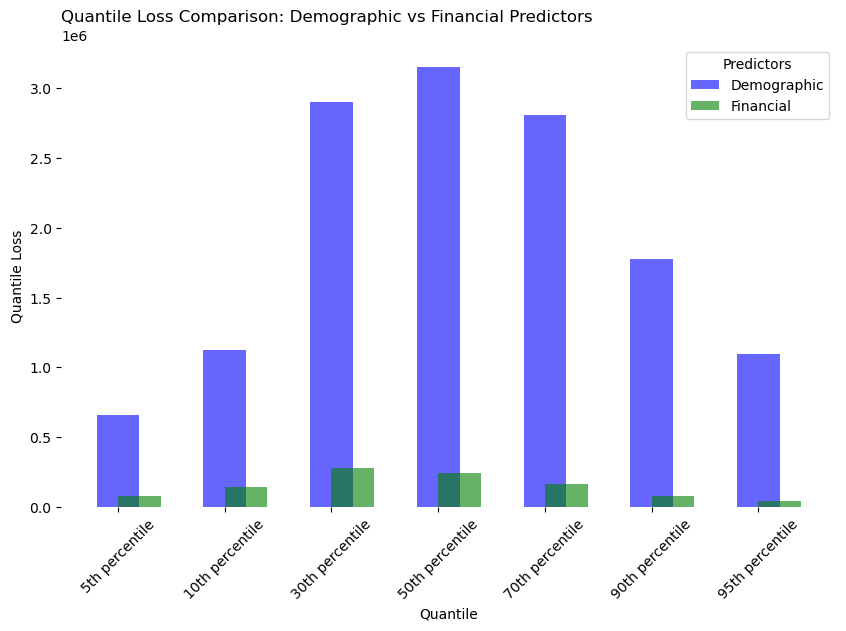

In [29]:
plt.figure(figsize=(10,6))
plt.bar(dem_loss_df.columns, dem_loss_df.loc["Test"], alpha=0.6, label="Demographic", width=0.4, align='center', color='blue')
plt.bar(fin_loss_df.columns, fin_loss_df.loc["Test"], alpha=0.6, label="Financial", width=0.4, align='edge', color='green')
plt.title("Quantile Loss Comparison: Demographic vs Financial Predictors", loc="left")
sns.despine(left=True, bottom=True)
plt.xlabel("Quantile")
plt.ylabel("Quantile Loss")
plt.legend(title="Predictors")
plt.xticks(rotation=45)
plt.show()

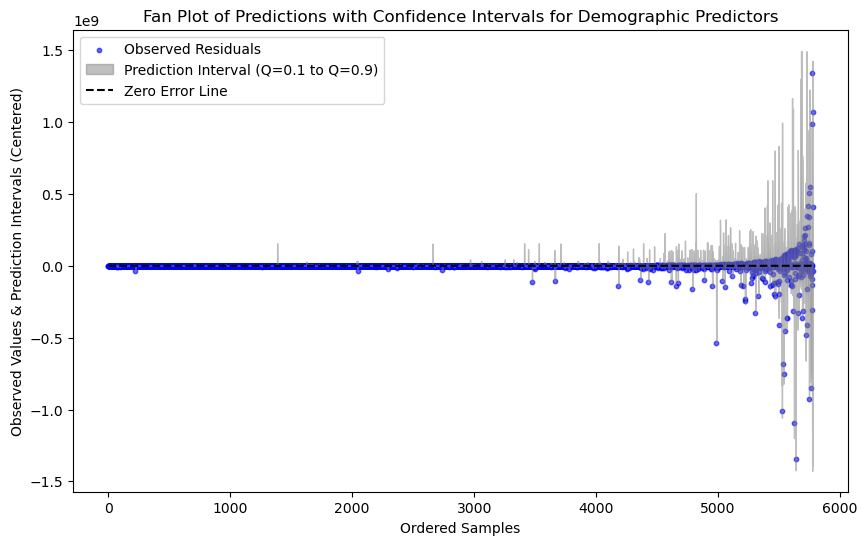

In [30]:
def plot_test_residuals(qrf, predictors, method, color):
    # Predict different quantiles
    q_10 = qrf.predict(test_df[predictors], mean_quantile=0.1)
    q_50 = qrf.predict(test_df[predictors], mean_quantile=0.5)
    q_90 = qrf.predict(test_df[predictors], mean_quantile=0.9)
    
    # Sort test samples for a smooth plot
    sorted_idx = np.argsort(y_test.values.flatten())
    y_sorted = y_test.iloc[sorted_idx].values.flatten()
    
    # Centered residuals (observed - predicted median)
    residuals = y_sorted - q_50.iloc[sorted_idx].values.flatten()
    
    # Compute lower and upper prediction intervals (also centered)
    lower_bound = q_10.iloc[sorted_idx].values.flatten() - q_50.iloc[sorted_idx].values.flatten()
    upper_bound = q_90.iloc[sorted_idx].values.flatten() - q_50.iloc[sorted_idx].values.flatten()
    
    # Create the fan plot
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(y_sorted)), residuals, color=color, alpha=0.6, s=10, label="Observed Residuals")
    plt.fill_between(range(len(y_sorted)), lower_bound, upper_bound, color='gray', alpha=0.5, label="Prediction Interval (Q=0.1 to Q=0.9)")
    plt.plot(range(len(y_sorted)), np.zeros_like(y_sorted), 'k--', label="Zero Error Line")
    plt.xlabel("Ordered Samples")
    plt.ylabel("Observed Values & Prediction Intervals (Centered)")
    plt.title(f"Fan Plot of Predictions with Confidence Intervals for {method} Predictors")
    plt.legend()
    plt.show()

plot_test_residuals(dem_qrf, dem_predictors, "Demographic", "blue")

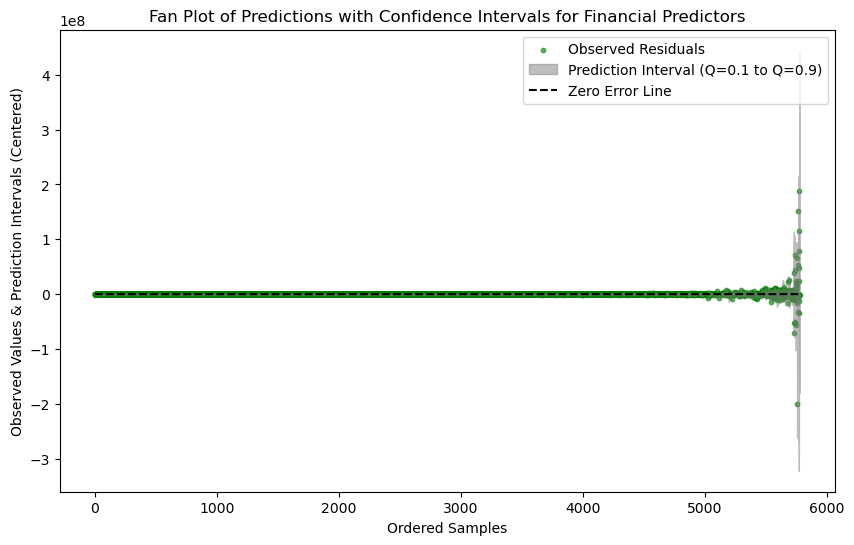

In [31]:
plot_test_residuals(fin_qrf, fin_predictors, "Financial", "green")

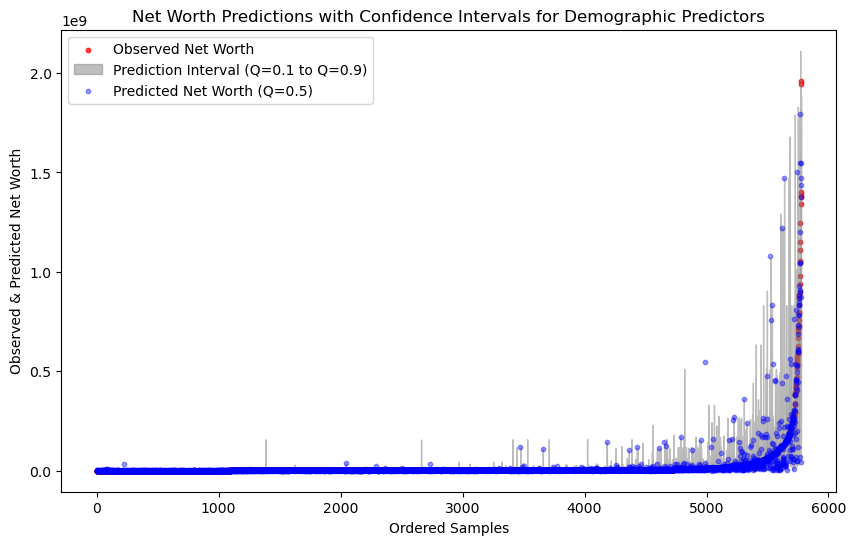

In [32]:
def plot_test_predictions(qrf, predictors, method, color):
    # Predict different quantiles
    q_10 = qrf.predict(test_df[predictors], mean_quantile=0.1)
    q_50 = qrf.predict(test_df[predictors], mean_quantile=0.5)
    q_90 = qrf.predict(test_df[predictors], mean_quantile=0.9)
    
    # Sort test samples for a smooth plot
    sorted_idx = np.argsort(y_test.values.flatten())
    y_sorted = y_test.iloc[sorted_idx].values.flatten()
    q_10_sorted = q_10.iloc[sorted_idx].values.flatten()
    q_50_sorted = q_50.iloc[sorted_idx].values.flatten()
    q_90_sorted = q_90.iloc[sorted_idx].values.flatten()
    
    # Plot the predicted Net Worth and its Confidence Intervals
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(y_sorted)), y_sorted, color='red', alpha=0.75, s=10, label="Observed Net Worth")
    plt.fill_between(range(len(y_sorted)), q_10_sorted, q_90_sorted, color='gray', alpha=0.5, label="Prediction Interval (Q=0.1 to Q=0.9)")
    plt.scatter(range(len(y_sorted)), q_50_sorted, color=color, alpha=0.4, s=10, label="Predicted Net Worth (Q=0.5)")
    plt.xlabel("Ordered Samples")
    plt.ylabel("Observed & Predicted Net Worth")
    plt.title(f"Net Worth Predictions with Confidence Intervals for {method} Predictors")
    plt.legend()
    plt.show()

plot_test_predictions(dem_qrf, dem_predictors, "Demographic", "blue")

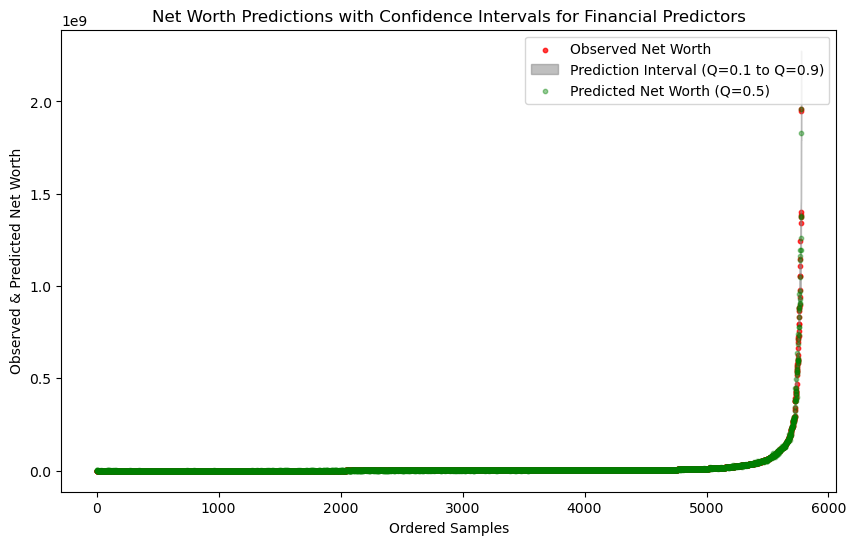

In [33]:
plot_test_predictions(fin_qrf, fin_predictors, "Financial", "green")

## Benchmarking Methods for Survey of Consumer Finances Imputation

Compared Methods: 

1. Quantile Regression Forests
2. Matching
3. OLS
4. QuantReg
5. Random Forests
6. GradientBoosting

### Preprocessing

In [51]:
mean = train_df.mean(axis=0)
std = train_df.std(axis=0)
train_df = (train_df - mean) / std
test_df = (test_df - mean) / std

### Quantile Regression Forests

In [52]:
# split data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, train_size=0.8, random_state=42)

y_train = train_df[IMPUTED_VARIABLES]
y_test = test_df[IMPUTED_VARIABLES]

qrf = QRF()
qrf.fit(train_df[PREDICTORS], train_df[IMPUTED_VARIABLES])

QUANTILES = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

# compute quantile loss for demographic predictors in train and test sets
train_losses = [np.mean(quantile_loss(q, y_train.values.flatten(),
                                          qrf.predict(train_df[PREDICTORS], mean_quantile=q).values.flatten()
                                         )) for q in QUANTILES]
test_losses = [np.mean(quantile_loss(q, y_test.values.flatten(),
                                         qrf.predict(test_df[PREDICTORS], mean_quantile=q).values.flatten()
                                        )) for q in QUANTILES]

# create dataframes for train and test losses
loss_df = pd.DataFrame([train_losses, test_losses], columns=quantiles_legend, index=["Train", "Test"])

loss_df

/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,459415.392521,8.161909e+05,1.444721e+06,1.482116e+06,1.229121e+06,9.997076e+05,6.961144e+05
Test,875513.211427,1.211838e+06,2.266221e+06,2.493329e+06,2.184923e+06,1.682978e+06,1.096967e+06


In [59]:
# define number of folds
K = 5 

quantile_losses = {"train": {q: [] for q in QUANTILES}, "test" : {q: [] for q in QUANTILES}}

kf = KFold(n_splits=K, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(data):
    train_df, test_df = data.iloc[train_idx], data.iloc[test_idx]

    y_train = train_df[IMPUTED_VARIABLES]
    y_test = test_df[IMPUTED_VARIABLES]

    qrf = QRF()
    qrf.fit(train_df[PREDICTORS], train_df[IMPUTED_VARIABLES])

    # compute quantile loss for each quantile
    for q in QUANTILES:
        y_pred_train = qrf.predict(train_df[PREDICTORS], mean_quantile=q).values.flatten()
        y_pred_test = qrf.predict(test_df[PREDICTORS], mean_quantile=q).values.flatten()
        train_loss = np.mean(quantile_loss(q, y_train.values.flatten(), y_pred_train))
        test_loss = np.mean(quantile_loss(q, y_test.values.flatten(), y_pred_test))
        quantile_losses["train"][q].append(train_loss)
        quantile_losses["test"][q].append(test_loss)

# compute average quantile losses for train and test
avg_quantile_losses_train = {f"{int(q*100)}th percentile": np.mean(quantile_losses["train"][q]) for q in QUANTILES}
avg_quantile_losses_test = {f"{int(q*100)}th percentile": np.mean(quantile_losses["test"][q]) for q in QUANTILES}

# create a dataframe to store both train and test losses
qrf_loss_df = pd.DataFrame([avg_quantile_losses_train, avg_quantile_losses_test], index=["Train", "Test"])

qrf_loss_df


/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,508900.772931,8.681492e+05,1.596949e+06,1.368721e+06,1.104342e+06,9.455935e+05,6.439730e+05
Test,813647.291731,1.197136e+06,2.431011e+06,2.552806e+06,2.232824e+06,1.684507e+06,1.115024e+06


In [54]:
def plot_method_loss(method, loss_df, QUANTILES, K):
    # extract quantile labels
    quantile_labels = [f"{int(q*100)}th" for q in QUANTILES]

    # extract train and test losses
    train_losses = loss_df.loc["Train"].values
    test_losses = loss_df.loc["Test"].values

    # Set bar width and positions
    x = np.arange(len(quantile_labels))
    bar_width = 0.35

    # Create bar chart for train and test losses
    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, train_losses, bar_width, label="Train Loss", color='skyblue', edgecolor='black')
    plt.bar(x + bar_width/2, test_losses, bar_width, label="Test Loss", color='salmon', edgecolor='black')

    # labels and title
    plt.xlabel("Quantile", fontsize=12)
    plt.ylabel("Average Quantile Loss", fontsize=12)
    plt.title(f"Quantile Loss Across {K} Folds for {method}", fontsize=14)
    plt.xticks(x, quantile_labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


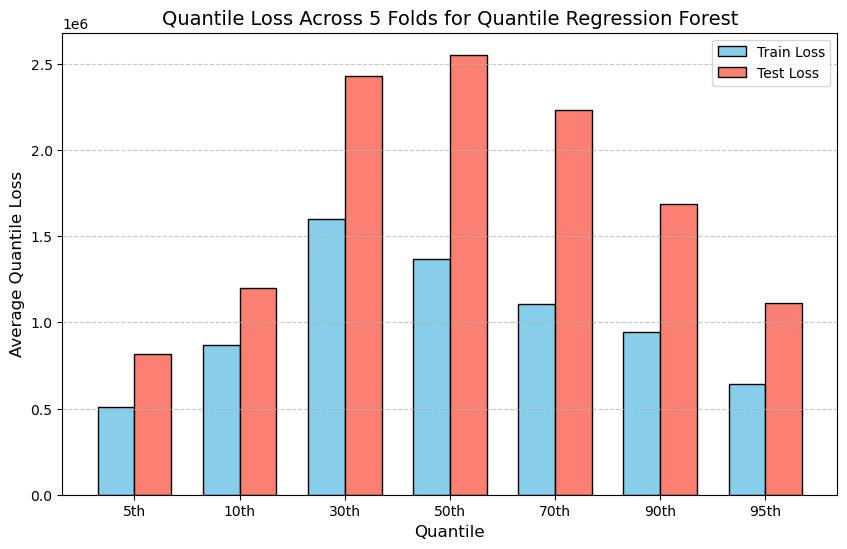

In [60]:
plot_method_loss("Quantile Regression Forest", qrf_loss_df, QUANTILES, K)

## Matching

In [56]:
#!pip install rpy2 --upgrade
import rpy2

# Install R package
%load_ext rpy2.ipython
%R install.packages('StatMatch', repos='https://cloud.r-project.org')

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Enable R-Python DataFrame conversion
pandas2ri.activate()
StatMatch = importr("StatMatch")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

The downloaded binary packages are in
	/var/folders/yg/xdp70k_n4qj9ph1_0lm435c00000gp/T//RtmpvBN8NN/downloaded_packages


probando la URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/StatMatch_1.4.3.tgz'
Content type 'application/x-gzip' length 593031 bytes (579 KB)
downloaded 579 KB



In [61]:
# split data into the same train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df = data.loc[train_df.index]  # Reassign correct indices
train_df = data.loc[train_df.index]  # Reassign correct indices

y_test = test_df[IMPUTED_VARIABLES]

# normalize predictor variables
mean = train_df[PREDICTORS].mean(axis=0)
std = train_df[PREDICTORS].std(axis=0)
train_df[PREDICTORS] = (train_df[PREDICTORS] - mean) / std
test_df[PREDICTORS] = (test_df[PREDICTORS] - mean) / std

# create a copy of the test set (to store imputed values later)
train_df_dup = train_df.copy()
test_df_dup = test_df.copy()

# remove imputed variables from test_df before matching
test_df = test_df.drop(columns=IMPUTED_VARIABLES, errors="ignore")

# Function for Nearest Neighbor Hotdeck Matching
def nnd_hotdeck_using_rpy2(receiver, donor, matching_variables, z_variables, donor_classes=None):
    """
    Perform statistical matching (nearest neighbor hotdeck imputation).
    """
    assert receiver is not None and donor is not None
    assert matching_variables is not None

    try:
        if donor_classes:
            out_NND = StatMatch.NND_hotdeck(
                data_rec=receiver,
                data_don=donor,
                match_vars=pd.Series(matching_variables),
                don_class=pd.Series(donor_classes),
                k_donor=1
            )
        else:
            out_NND = StatMatch.NND_hotdeck(
                data_rec=receiver,
                data_don=donor,
                match_vars=pd.Series(matching_variables),
                k_donor=1
            )
    except Exception as e:
        print("Error in hotdeck matching:", e)

    donor_idx = np.array(out_NND[0], dtype=int)
    receiver_idx = np.array(receiver.index, dtype=int)

    if len(donor_idx) != len(receiver_idx):
        raise ValueError("Mismatch between donor_idx and test_df lengths. "
                        f"{len(donor_idx)} vs {len(receiver_idx)}")

    # Create the Nx2 "matching ID" matrix that create_fused() expects
    mtc_ids = np.column_stack((receiver_idx, donor_idx))

    # Now call create_fused with mtc_ids
    fused_0 = StatMatch.create_fused(
        data_rec=receiver,  # test_df
        data_don=donor,     # train_df
        mtc_ids=mtc_ids,
        z_vars=pd.Series(z_variables)
    )

    # Convert R dataframe to Pandas dataframe
    return pandas2ri.rpy2py_dataframe(fused_0)


In [58]:
# Perform statistical matching
fused0 = nnd_hotdeck_using_rpy2(
    receiver=test_df,
    donor=train_df,
    matching_variables=PREDICTORS,
    z_variables=IMPUTED_VARIABLES,
    donor_classes=None
)

ValueError: Mismatch between donor_idx and test_df lengths. 11554 vs 5777

In [ ]:
# Store imputed values in preds DataFrame for evaluation
preds = pd.DataFrame({
    'method': 'Matching',
    'q': np.tile(QUANTILES, len(test_df)),
    'x': np.repeat(test_df.index, len(QUANTILES)),
    'label': np.repeat(y_test.values.flatten(), len(QUANTILES)),
    'pred': np.repeat(fused0[IMPUTED_VARIABLES].values.flatten(), len(QUANTILES))
})

# Display first few rows
print(preds.head())

     method     q     x         label  pred
0  Matching  0.05  9199 -68856.794702   NaN
1  Matching  0.10  9199 -68856.794702   NaN
2  Matching  0.30  9199 -68856.794702   NaN
3  Matching  0.50  9199 -68856.794702   NaN
4  Matching  0.70  9199 -68856.794702   NaN


### OLS

In [ ]:
import statsmodels.api as sm
from scipy.stats import norm

In [62]:
def ols_quantile(m, X, q):
    # m: OLS model.
    # X: X matrix.
    # q: Quantile.
    #
    # Set alpha based on q. Vectorized for different values of q.
    mean_pred = m.predict(X)
    se = np.sqrt(m.scale)
    return mean_pred + norm.ppf(q) * se

In [63]:
quantile_losses_ols = {"train": {q: [] for q in QUANTILES}, "test": {q: [] for q in QUANTILES}}

for train_idx, test_idx in kf.split(data):
    train_df, test_df = data.iloc[train_idx], data.iloc[test_idx]

    y_train = train_df[IMPUTED_VARIABLES]
    y_test = test_df[IMPUTED_VARIABLES]

    # add constant for OLS
    x_train = sm.add_constant(train_df[PREDICTORS])
    x_test = sm.add_constant(test_df[PREDICTORS])

    # fit OLS model
    ols_model = sm.OLS(y_train, x_train).fit()

    # compute quantile loss for each quantile
    for q in QUANTILES:
        y_pred_train = ols_quantile(ols_model, x_train, q)
        y_pred_test = ols_quantile(ols_model, x_test, q)
        train_loss = np.mean(np.abs(y_train.values.flatten() - y_pred_train.values.flatten()))
        test_loss = np.mean(np.abs(y_test.values.flatten() - y_pred_test.values.flatten()))
        quantile_losses_ols["train"][q].append(train_loss)
        quantile_losses_ols["test"][q].append(test_loss)

# compute average quantile losses for train and test
avg_quantile_losses_train_ols = {f"{int(q*100)}th percentile": np.mean(quantile_losses_ols["train"][q]) for q in QUANTILES}
avg_quantile_losses_test_ols = {f"{int(q*100)}th percentile": np.mean(quantile_losses_ols["test"][q]) for q in QUANTILES}

# create a dataframe to store both train and test losses
ols_loss_df = pd.DataFrame([avg_quantile_losses_train_ols, avg_quantile_losses_test_ols], index=["Train", "Test"])

ols_loss_df

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,8.035239e+07,6.319842e+07,2.800911e+07,1.129672e+07,3.275195e+07,6.721998e+07,8.401729e+07
Test,8.046019e+07,6.331117e+07,2.813116e+07,1.141502e+07,3.286725e+07,6.733995e+07,8.413717e+07


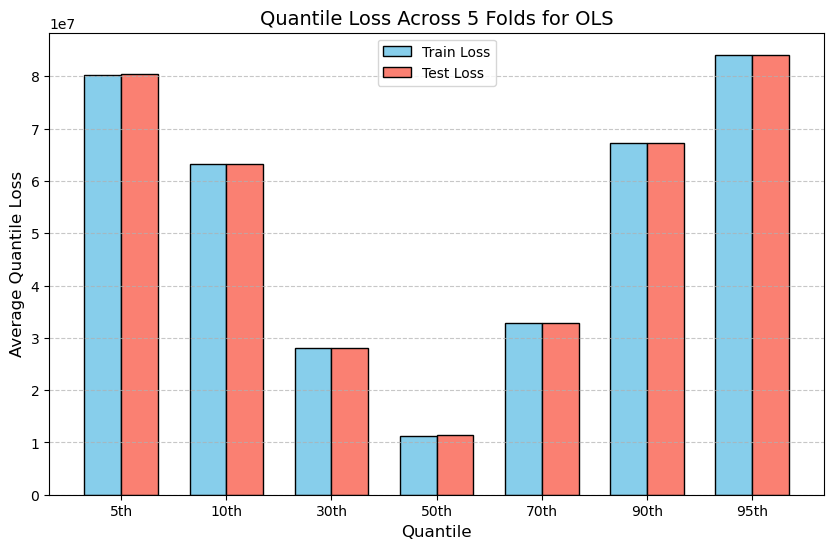

In [64]:
plot_method_loss("OLS", ols_loss_df, QUANTILES, K)

### QuantReg

In [ ]:
quantreg_full = sm.QuantReg(y_train, x_train)

preds.loc[preds.method == 'QuantReg', 'pred'] = np.concatenate(
    [quantreg_full.fit(q=q).predict(x_test) for q in QUANTILES])

In [ ]:
quantile_losses_qr = {"train": {q: [] for q in QUANTILES}, "test": {q: [] for q in QUANTILES}}

for train_idx, test_idx in kf.split(data):
    train_df, test_df = data.iloc[train_idx], data.iloc[test_idx]

    y_train = train_df[IMPUTED_VARIABLES]
    y_test = test_df[IMPUTED_VARIABLES]

    # add constant for QuantReg
    x_train = sm.add_constant(train_df[PREDICTORS])
    x_test = sm.add_constant(test_df[PREDICTORS])

    # fit and predict for each quantile
    for q in QUANTILES:
        quantreg_model = sm.QuantReg(y_train, x_train).fit(q=q)
        y_pred_train = quantreg_model.predict(x_train)
        y_pred_test = quantreg_model.predict(x_test)

        # compute quantile loss
        train_loss = np.mean(np.abs(y_train.values.flatten() - y_pred_train.values.flatten()))
        test_loss = np.mean(np.abs(y_test.values.flatten() - y_pred_test.values.flatten()))
        quantile_losses_qr["train"][q].append(train_loss)
        quantile_losses_qr["test"][q].append(test_loss)

# compute average quantile losses for train and test
avg_quantile_losses_train_qr = {f"{int(q*100)}th percentile": np.mean(quantile_losses_qr["train"][q]) for q in QUANTILES}
avg_quantile_losses_test_qr = {f"{int(q*100)}th percentile": np.mean(quantile_losses_qr["test"][q]) for q in QUANTILES}

# create a dataframe to store both train and test losses for QuantReg
quantreg_loss_df = pd.DataFrame([avg_quantile_losses_train_qr, avg_quantile_losses_test_qr], index=["Train", "Test"])

quantreg_loss_df

/Users/movil1/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/movil1/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/movil1/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/movil1/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/movil1/anaconda3/lib/python3.11/site-

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,1.194896e+07,1.090204e+07,8.867122e+06,8.109575e+06,9.039018e+06,1.746481e+07,2.425136e+07
Test,1.193932e+07,1.094884e+07,8.963877e+06,8.344511e+06,9.153171e+06,1.803404e+07,2.438265e+07


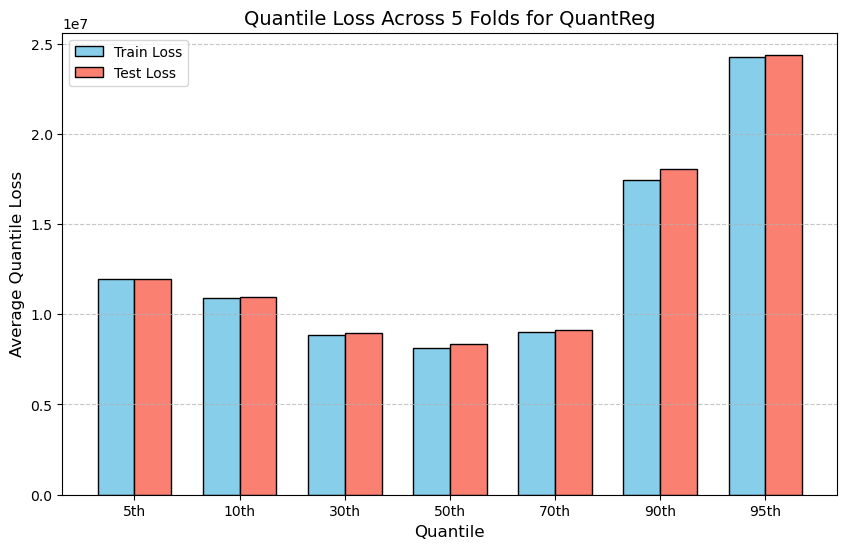

In [67]:
plot_method_loss("QuantReg", quantreg_loss_df, QUANTILES, K)

### Random Forests

### Gradient Boosting

### Comparing Across Methods

In [73]:
quantreg_loss_df["Method"] = "QuantReg"
ols_loss_df["Method"] = "OLS"
qrf_loss_df["Method"] = "QRF"

# Convert each DataFrame from wide to long format
quantreg_long = quantreg_loss_df.reset_index().melt(id_vars=["index", "Method"], var_name="Quantile", value_name="Loss")
ols_long = ols_loss_df.reset_index().melt(id_vars=["index", "Method"], var_name="Quantile", value_name="Loss")
qrf_long = qrf_loss_df.reset_index().melt(id_vars=["index", "Method"], var_name="Quantile", value_name="Loss")

# Rename the 'index' column to 'Split' (Train/Test)
for df in [quantreg_long, ols_long, qrf_long]:
    df.rename(columns={"index": "Split"}, inplace=True)

# Concatenate all into a single DataFrame
combined_loss_df = pd.concat([quantreg_long, ols_long, qrf_long], ignore_index=True)

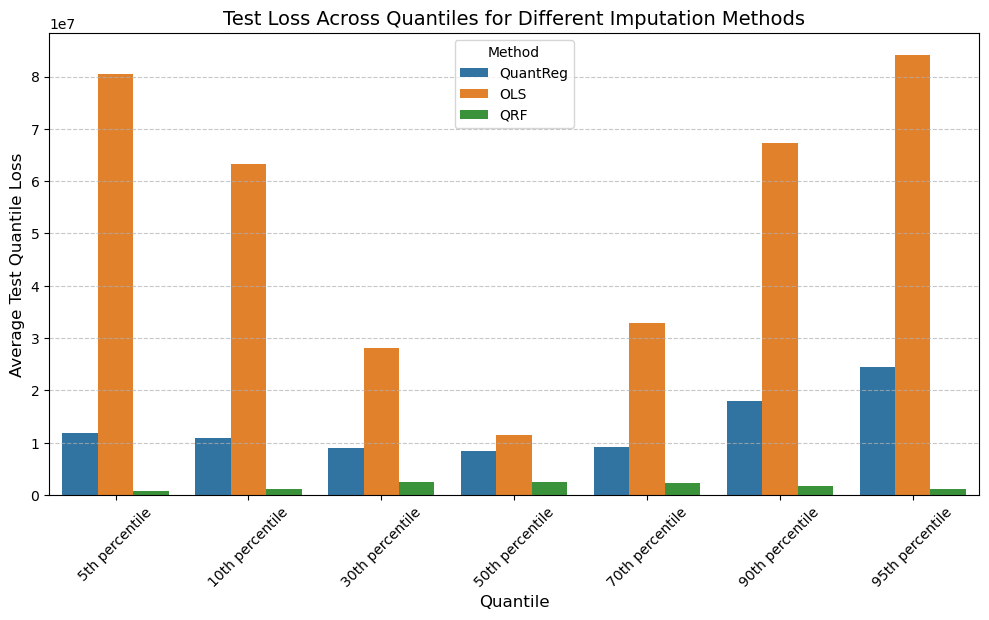

In [72]:
test_loss_df = combined_loss_df[combined_loss_df["Split"] == "Test"]

plt.figure(figsize=(12, 6))
sns.barplot(data=test_loss_df, x="Quantile", y="Loss", hue="Method", dodge=True)
plt.xlabel("Quantile", fontsize=12)
plt.ylabel("Average Test Quantile Loss", fontsize=12)
plt.title("Test Loss Across Quantiles for Different Imputation Methods", fontsize=14)
plt.legend(title="Method")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()